In [1]:
!pip install nibabel tqdm scikit-image

#리눅스 사용 시 !을 쓴다

In [37]:
import os
import sys
import random
import math
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
from scipy.ndimage import zoom

from sklearn.model_selection import train_test_split

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.autograd import Variable

import tensorflow as tf
from tensorflow.python.client import device_lib

In [3]:
#구글 드라이브를 쓰자
from google.colab import drive
#루트를 정해준다.
ROOT = "/content/drive"
print(ROOT)

drive.mount(ROOT) #we mount the google drive at /content/drive

#import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join


MY_GOOGLE_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks'

print("MY_GOOGLE_DRIVE_PATH: ", MY_GOOGLE_DRIVE_PATH)

%cd "{MY_GOOGLE_DRIVE_PATH}"


ModuleNotFoundError: No module named 'google.colab'

In [38]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())
tf.test.is_gpu_available()
print(K._get_available_gpus())


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15528959159759631751
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2914163099
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6407459750858427225
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
['/device:GPU:0']


In [42]:
def get_train_data():
#   dataset_dir = os.path.join(MY_GOOGLE_DRIVE_PATH, 'srcnn', 'CT','Mask_train_set')
#   # files_list = os.listdir(dataset_dir)

#   x_train_path = os.path.join(dataset_dir, 'x_train.npy')
#   x_val_path = os.path.join(dataset_dir, 'x_val.npy')
#   y_train_path = os.path.join(dataset_dir, 'y_train.npy')
#   y_val_path = os.path.join(dataset_dir, 'y_val.npy')
    x_train_path = "dataset/x_train.npy"
    x_val_path = "dataset/x_val.npy" 
    y_train_path = "dataset/y_train.npy"
    y_val_path = "dataset/y_val.npy"
    
    x_train = np.load(x_train_path)
    x_val = np.load(x_val_path)
    y_train = np.load(y_train_path)
    y_val = np.load(y_val_path)

    print(x_train.shape, y_train.shape)
    print(x_val.shape, y_val.shape)

    return x_train, x_val, y_train, y_val


In [168]:
def get_train_data2():
    
    train_path = "Mask_train_set/ct_scans"
    train_masked_path = "Mask_train_set/lung_mask"
    
    train_set_list = os.listdir(train_path)
    train_masked_set_list = os.listdir(train_masked_path)
    size = 0
    count = 0
    img_set = np.empty(( 1912, 256, 256, 1), dtype=np.float32)
    img_masked_set = np.empty(( 1912, 256, 256, 1), dtype=np.float32)
    #1912
    for i, file_name in enumerate(train_set_list):
        image_name =os.path.join(train_path, file_name)
        image_masked_name =os.path.join(train_masked_path, train_masked_set_list[i])
        print(image_name)
        print(image_masked_name)
        
        image = nib.load(image_name)
        image_masked = nib.load(image_masked_name)
        
        image_array = np.array(image.get_fdata(), dtype=np.float32)
        image_masked_array = np.array(image_masked.get_fdata(), dtype=np.float32)
        
        image_array = image_array.T
        image_masked_array = image_masked_array.T
#         size = size + len(image_array)
#     print(size)

        for i, image in enumerate(image_array) :
            img = resize(image, output_shape=(256, 256, 1), preserve_range=True)
            img_masked = resize(image_masked_array[i], output_shape=(256,256,1), preserve_range = True)
            
            img_set[count] = img
            img_masked_set[count] = img_masked
            count = count + 1
    
    img_masked_set = img_masked_set/255
    img_masked_set[img_masked_set > 0] =7.84313772e-03
    
#     fig, ax = plt.subplots(50, 2, figsize=(10, 100))
    
#     for i in range(50):
#         ax[i, 0].imshow(image_array[i].squeeze(), cmap='gray')
#         ax[i, 1].imshow(image_masked_array[i].squeeze(), cmap='gray')
            
    x_train, x_val, y_train, y_val = train_test_split(img_set, img_masked_set, test_size=0.1)
    
    np.save('dataset/x_train.npy', x_train)
    np.save('dataset/y_train.npy', y_train)
    np.save('dataset/x_val.npy', x_val)
    np.save('dataset/y_val.npy', y_val)
    
    return img_masked_set
    
    

In [169]:
img_masked_set=get_train_data2()


Mask_train_set/ct_scans\coronacases_org_001.nii
Mask_train_set/lung_mask\coronacases_001.nii
Mask_train_set/ct_scans\coronacases_org_002.nii
Mask_train_set/lung_mask\coronacases_002.nii
Mask_train_set/ct_scans\coronacases_org_003.nii
Mask_train_set/lung_mask\coronacases_003.nii
Mask_train_set/ct_scans\coronacases_org_004.nii
Mask_train_set/lung_mask\coronacases_004.nii
Mask_train_set/ct_scans\coronacases_org_005.nii
Mask_train_set/lung_mask\coronacases_005.nii
Mask_train_set/ct_scans\radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii
Mask_train_set/lung_mask\radiopaedia_10_85902_1.nii
Mask_train_set/ct_scans\radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii
Mask_train_set/lung_mask\radiopaedia_10_85902_3.nii
Mask_train_set/ct_scans\radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii
Mask_train_set/lung_mask\radiopaedia_14_85914_0.nii
Mask_train_set/ct_scans\radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm.nii
Mask_train_set/lung_mask\radiopaedia_4_85506_1.nii
Mask_train_set/ct

(256, 256, 1)
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.00784314]
 [0.00784314]
 [0.00784314]
 [0.00784314]
 [0.00784314]
 [0.00784314]
 [0.00784314]
 [0.00784314]
 [0.00784314]
 [0.00784314]
 [0.00784314]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.  

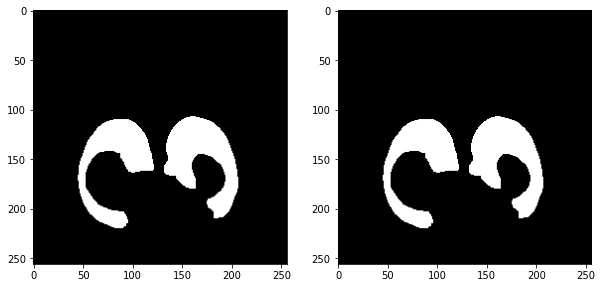

In [160]:
temp = np.empty(( 256, 256, 1), dtype=np.float32)
temp = img_masked_set[100]
print(temp.shape)
print(temp[150])
print(temp[100][150])
print(temp[100][100])
temp[temp > 0] = 7.84313772e-03
#3.92156886e-03
#7.84313772e-03
ig, ax = plt.subplots(1, 2, figsize=(10, 100))
ax[0].imshow(temp.squeeze(), cmap='gray')
ax[1].imshow(img_masked_set[100].squeeze(), cmap='gray')

In [174]:
def mask_model(x_train, x_val, y_train, y_val) :
  
    inputs = Input(shape=(256, 256, 1))

  
    #down sampling 
    f = 8
    layers = []
    net = inputs
  
    for i in range(0, 6):
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        layers.append(net)
        net = MaxPooling2D((2, 2), strides=(2, 2)) (net)
        f = f*2
    ff2 = 256
  
    #bottleneck 
    j = len(layers) - 1
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (net)
    net = Concatenate(axis=3)([net, layers[j]])
    j = j -1 
  
    #upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        net = Conv2D(f, 3, activation='relu', padding='same') (net)
        print(net.shape)
        net = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (net)
        print(net.shape)
        net = Concatenate(axis=3)([net, layers[j]])
        j = j -1 
    
  
    #classification 
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    net = Conv2D(f, 3, activation='relu', padding='same') (net)
    outputs = Conv2D(1, 1, activation='sigmoid') (net)


    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', 'mse'])

    model.summary()
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=16, 
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)])
  
    fig, ax = plt.subplots(2, 2, figsize=(10, 7))

    ax[0, 0].set_title('loss')
    ax[0, 0].plot(history.history['loss'], 'r')
    ax[0, 1].set_title('acc')
    ax[0, 1].plot(history.history['acc'], 'b')

    ax[1, 0].set_title('val_loss')
    ax[1, 0].plot(history.history['val_loss'], 'r--')
    ax[1, 1].set_title('val_acc')
    ax[1, 1].plot(history.history['val_acc'], 'b--')

    preds = model.predict(x_val)

    fig, ax = plt.subplots(40, 3, figsize=(10, 100))

    for i in range(40):
        ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
        ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
        ax[i, 2].imshow(preds[i].squeeze(), cmap='gray')

    return model

(1720, 256, 256, 1) (1720, 256, 256, 1)
(192, 256, 256, 1) (192, 256, 256, 1)
(None, 8, 8, 256)
(None, 16, 16, 128)
(None, 16, 16, 128)
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 64, 64, 32)
(None, 64, 64, 32)
(None, 128, 128, 16)
(None, 128, 128, 16)
(None, 256, 256, 8)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_243 (Conv2D)             (None, 256, 256, 8)  80          input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_244 (Conv2D)             (None, 256, 256, 8)  584         conv2d_243[0][0]                 
________________

108/108 [==============================] - 36s 264ms/step - loss: 0.7079 - acc: 0.8383 - mse: 0.0361 - val_loss: 0.0104 - val_acc: 0.8777 - val_mse: 7.2076e-05
Epoch 2/100
108/108 [==============================] - 27s 251ms/step - loss: 0.0208 - acc: 0.8747 - mse: 7.8369e-04 - val_loss: 0.0082 - val_acc: 0.8777 - val_mse: 1.5800e-04
Epoch 3/100
108/108 [==============================] - 27s 252ms/step - loss: 0.0102 - acc: 0.8720 - mse: 1.8249e-04 - val_loss: 0.0067 - val_acc: 0.8777 - val_mse: 8.4429e-06
Epoch 4/100
108/108 [==============================] - 27s 252ms/step - loss: 0.0076 - acc: 0.8741 - mse: 3.6186e-05 - val_loss: 0.0062 - val_acc: 0.8777 - val_mse: 3.2465e-06
Epoch 5/100
108/108 [==============================] - 28s 258ms/step - loss: 0.0076 - acc: 0.8751 - mse: 5.7520e-05 - val_loss: 0.0066 - val_acc: 0.8777 - val_mse: 1.6423e-05
Epoch 6/100
108/108 [==============================] - 28s 261ms/step - loss: 0.0082 - acc: 0.8769 - mse: 2.0011e-05 - val_loss: 0.0059 

108/108 [==============================] - 27s 253ms/step - loss: 0.0057 - acc: 0.8771 - mse: 2.6839e-07 - val_loss: 0.0056 - val_acc: 0.8777 - val_mse: 2.8108e-07
Epoch 47/100
108/108 [==============================] - 28s 259ms/step - loss: 0.0057 - acc: 0.8770 - mse: 2.7322e-07 - val_loss: 0.0056 - val_acc: 0.8777 - val_mse: 2.8062e-07
Epoch 48/100
108/108 [==============================] - 29s 265ms/step - loss: 0.0058 - acc: 0.8735 - mse: 2.7349e-07 - val_loss: 0.0056 - val_acc: 0.8777 - val_mse: 2.8203e-07
Epoch 49/100
108/108 [==============================] - 29s 264ms/step - loss: 0.0058 - acc: 0.8740 - mse: 2.7009e-07 - val_loss: 0.0056 - val_acc: 0.8777 - val_mse: 2.8020e-07
Epoch 50/100
108/108 [==============================] - 28s 260ms/step - loss: 0.0057 - acc: 0.8758 - mse: 2.6642e-07 - val_loss: 0.0056 - val_acc: 0.8777 - val_mse: 2.7718e-07
Epoch 51/100
108/108 [==============================] - 28s 260ms/step - loss: 0.0056 - acc: 0.8785 - mse: 2.6341e-07 - val_loss

108/108 [==============================] - 27s 254ms/step - loss: 0.0058 - acc: 0.8746 - mse: 2.3651e-07 - val_loss: 0.0056 - val_acc: 0.8777 - val_mse: 2.5239e-07
Epoch 93/100
108/108 [==============================] - 27s 254ms/step - loss: 0.0057 - acc: 0.8770 - mse: 2.4019e-07 - val_loss: 0.0056 - val_acc: 0.8777 - val_mse: 2.5114e-07
Epoch 94/100
108/108 [==============================] - 27s 253ms/step - loss: 0.0059 - acc: 0.8723 - mse: 2.4722e-07 - val_loss: 0.0056 - val_acc: 0.8777 - val_mse: 2.4800e-07
Epoch 95/100
108/108 [==============================] - 28s 259ms/step - loss: 0.0057 - acc: 0.8763 - mse: 2.3411e-07 - val_loss: 0.0056 - val_acc: 0.8777 - val_mse: 2.5065e-07
Epoch 96/100
108/108 [==============================] - 28s 264ms/step - loss: 0.0058 - acc: 0.8751 - mse: 2.3641e-07 - val_loss: 0.0056 - val_acc: 0.8777 - val_mse: 2.4781e-07
Epoch 97/100
108/108 [==============================] - 29s 265ms/step - loss: 0.0057 - acc: 0.8758 - mse: 2.4305e-07 - val_loss

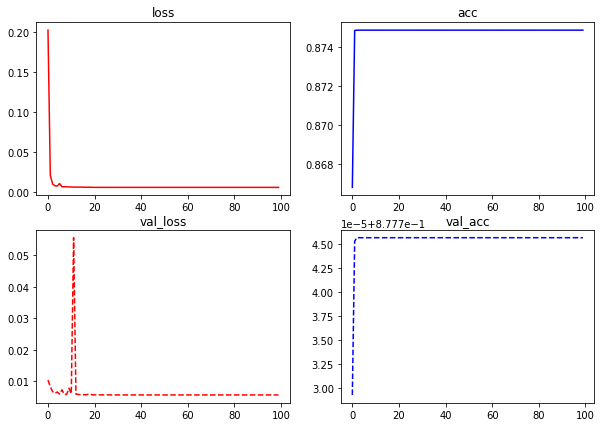

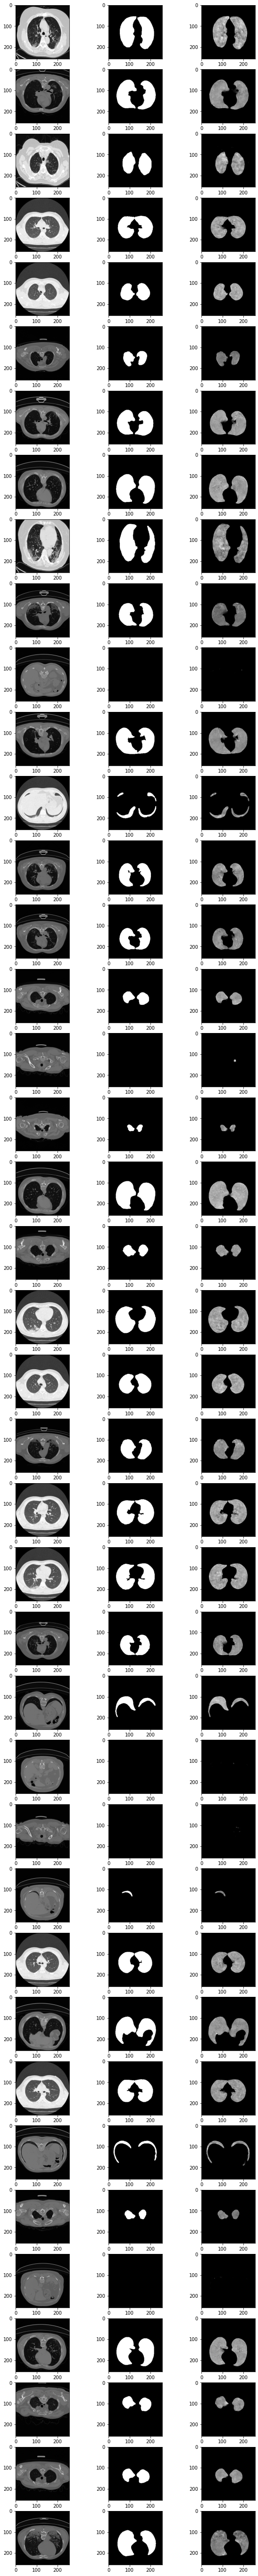

In [175]:
x_train, x_val, y_train, y_val = get_train_data()
model = mask_model(x_train, x_val, y_train, y_val)

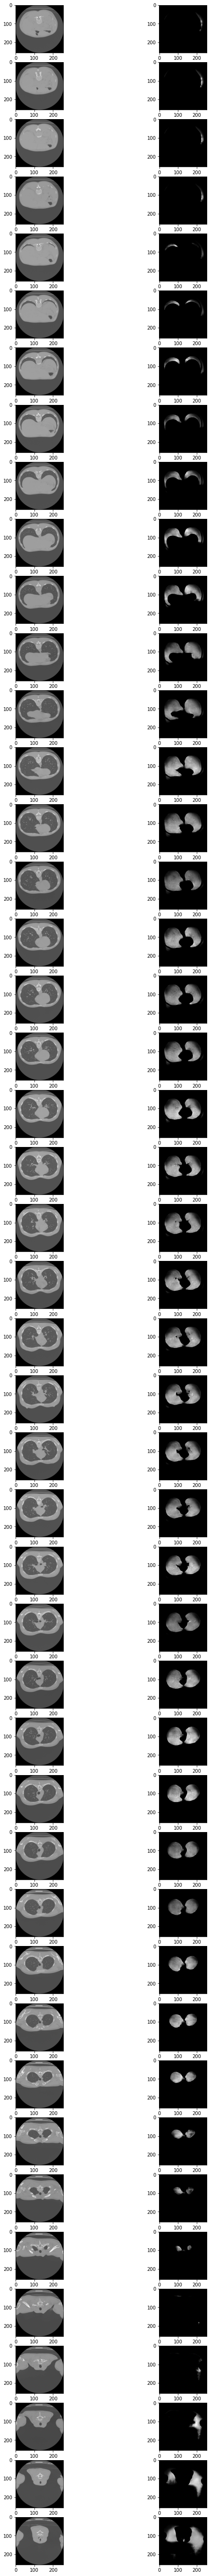

In [176]:
# test_data_dir = os.path.join(MY_GOOGLE_DRIVE_PATH, 'srcnn', 'CT','preprocessing')
# test_data_path = os.path.join(test_data_dir, 'study_0234.nii.gz')

test_data_path = "study_0234.nii.gz"

raw_image = nib.load(test_data_path)
raw_array = np.array(raw_image.get_fdata(), dtype=np.float32)
images = raw_array.T
count = 0
img_data = np.empty(( len(images), 256, 256, 1), dtype=np.float32)
for i, image_array in enumerate(images) :
    img = resize(image_array, output_shape=(256, 256, 1), preserve_range=True)
    img_data[i] = img

preds = model.predict(img_data)

fig, ax = plt.subplots(len(img_data), 2, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(img_data[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='gray')

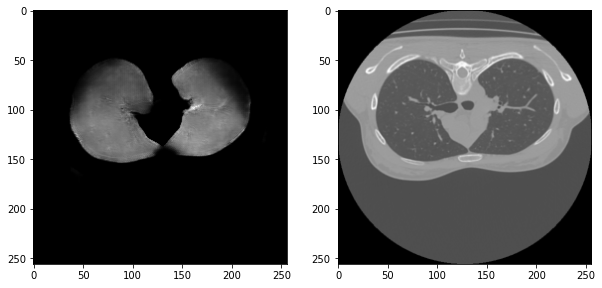

In [180]:

fig, ax = plt.subplots(1, 2, figsize=(10, 100))
ax[0].imshow(preds[28].squeeze(), cmap='gray')
ax[1].imshow(img_data[28].squeeze(), cmap='gray')

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.51938351e-37]
 [7.95259567e-29]
 [1.27819869e-17]
 [3.31990434e-15]
 [1.19280048e-15]
 [8.23318085e-13]
 [8.88901279e-12]
 [2.36391982e-11]
 [4.17568513e-13]
 [2.13573256e-12]
 [7.22659571e-11]
 [2.27164398e-10]
 [3.00356469e-08]
 [2.65983431e-07]
 [1.50238781e-03]
 [2.52637733e-03]
 [2.53768079e-03]
 [2.45691766e-03]
 [3.13201779e-03]
 [3.14906565e-03]
 [3.41481483e-03]
 [3.31709208e-03]
 [3.85106588e-03]
 [4.18047654e-03]
 [4.74635279e-03]
 [4.90217842e-03]
 [5.28661674e-03]
 [5.37945982e-03]
 [5.75747481e-03]
 [5.77479554e-03]
 [5.99425519e-03]
 [6.08086446e-03]
 [6.416586

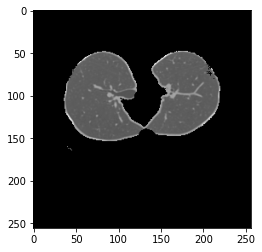

In [202]:
#plt.imshow(preds[28].squeeze(), cmap='gray')
image_test = img_data[28]
image_test = resize(image_test, output_shape=(256, 256), preserve_range=True)
pr = resize(preds[28], output_shape=(256, 256), preserve_range=True)
print(pr[100])
image_test[pr < 0.00049] = -2048
# print(pr[100])
plt.imshow(image_test.squeeze(), cmap='gray')

In [17]:
print(y_val[20][1])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

In [ ]:
def preprocessing(image_name_raw):
  #nii파일을 nibabel으로 불러온다.
  raw_image = nib.load(image_name_raw)
  
  #get_fdata 다른 헤더정보도 가져온다.(여러정보)
  raw_array = np.array(raw_image.get_fdata(), dtype=np.float32)

  image = raw_array.T
  # image[image == -2048] = 2048
  #image[image > -815] = 2048
  #image[image <= -815] = 2048
  # image[image != 2048] = -2048
  #print(image[27][300])
  plt.imshow(image[27], cmap = 'gray')
  return image

In [ ]:
#다운 샘플링을 가지고 원본이미지에 가깝게 만들어준다.
def get_lr(image) :
  #1/3만큼 크기로 만든다..
  downscaled_lr = zoom(image, 1/3.0, order = 2, prefilter= False)

  #3만큼 올린다.
  lr = np.clip(zoom(downscaled_lr, 3, order = 2, prefilter=False), 0, image.max())
  return lr


In [ ]:
#dataset 클래스 정리
class BrainDataset(DataLoader):
  def __init__(self):
    #이미지를 불러와서 데이터 셋으로 만들겠다.
    self.dataset_dir = os.path.join(MY_GOOGLE_DRIVE_PATH, 'srcnn', 'CT','preprocessing')
    
    #list 로 만듬
    self.files_list = os.listdir(self.dataset_dir)

    #메모리에 lr과 hr 저장해오는것을 가져오기 위한 변수들.
    self.image_hr_list = []
    self.image_lr_list = []
    
#   for file_name in tqdm(self.files_list):
    for file_name in self.files_list:
      print(file_name)

      #데이터 셋에 있는 file_name을 가져온다
      image_name_raw = os.path.join(self.dataset_dir, file_name)
      # print(image_name_raw)

      #전처리
      image = preprocessing(image_name_raw)
      H, W, D = image.shape

      
      input_image = image[27]
      segmentation = mask.apply(input_image)  # default model is U-net(R231)
      
      model = lungmask.mask.get_model('unet', 'LTRCLobes')
      segmentation = lungmask.mask.apply(input_image, model)
      
      plt.imshow(segmentation[27])
      

      for i in range(H):
        #까만 이미지만 아니면 통과
        if np.any(image[i]):
          lr = get_lr(image[i])

          #배치 사이즈를 제일 앞에 두고 그다음 채널수를 앞에 두는데
          #채널이 중간에 엄청 많으니 새로 만드는 작업을 한다.
          self.image_hr_list.append(image[i,np.newaxis, :, :])
          self.image_lr_list.append(lr[np.newaxis, :, :])

  def __getitem__(self, index): #몇번째 데이터를 리턴해라이다.
    return self.image_lr_list[index], self.image_hr_list[index]
  def __len__(self): #몇번째 index가 있느냐
    return len(self.image_hr_list)

study_0234.nii.gz


NameError: ignored

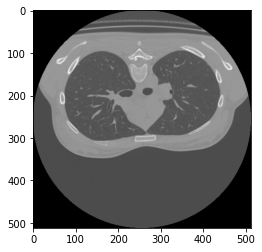

In [ ]:
testData = BrainDataset()